In [52]:
# Download the dataset
import os
from pathlib import Path
from datasets import load_dataset

# dataset = load_dataset("chittaranjankhatua/car_damage_pub")

# folder = 'car_damage'
# path = Path(folder)
# if not path.exists():
#     os.mkdir(folder)
# 
# # Writes dataset to file
# for i in range(len(dataset['train']["image"])):
#     image = dataset['train']["image"][i]
#     image_name = str('car_damage/')+str(i)+str('.jpg')
#     # Check if file exists
#     file = Path(image_name)
#     if not file.exists():
# 
#         # File does not exist, write image
#         image.save(image_name)
# 
#     else:
# 
#         # File already exists, skip writing
#         print(f'{image_name} already exists, skipping...')

In [8]:
# Data visualization
import matplotlib.pyplot as plt
from PIL import Image

def display_multiple_images(file_names):
    num_images = len(file_names)
    fig, axes = plt.subplots(1, num_images)
    fig.set_figwidth(5 * num_images)
    for ax, file_name in zip(axes, file_names):
        ax.imshow(Image.open(file_name))
        ax.axis("off")
    plt.show()

def display_single_image(file_name):
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(3)
    ax.imshow(Image.open(file_name))
    ax.axis("off")

In [9]:
import json
import base64
import boto3

# calls Amazon Bedrock to get a vector from either an image, text, or both
def get_multimodal_vector(input_image_base64=None, input_text=None):
    bedrock = boto3.client(service_name='bedrock-runtime')
    request_body = {}
    if input_text:
        request_body["inputText"] = input_text
    if input_image_base64:
        request_body["inputImage"] = input_image_base64
    request_body["embeddingConfig"] = {"outputEmbeddingLength": 1024}
    body = json.dumps(request_body)
    response = bedrock.invoke_model(
        body=body, 
        modelId="amazon.titan-embed-image-v1", 
        accept="application/json", 
        contentType="application/json"
    )
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get("embedding")
    return embedding

# creates a vector from an image file path
def get_vector_from_file(file_path):
    with open(file_path, "rb") as image_file:
        input_image_base64 = base64.b64encode(image_file.read()).decode('utf8')    
    vector = get_multimodal_vector(input_image_base64 = input_image_base64)
    return vector

In [10]:
# embed query testing for an image
embeddings = get_vector_from_file('./car_damage/0.jpg')
print(len(embeddings)) # length of embedding dimensions = 1 x 384
print(embeddings[:5])  # only include the first 5 elements

FileNotFoundError: [Errno 2] No such file or directory: './car_damage/0.jpg'

In [11]:
from PIL import Image
import os
import chromadb
client = chromadb.HttpClient()

from chromadb import Documents, EmbeddingFunction, Embeddings

class TitanEmbedFunction(EmbeddingFunction):
    def __call__(self, files: Documents) -> Embeddings:
        # embed the documents somehow
        return [get_vector_from_file(file) for file in files]

class TitanTextEmbedFunction(EmbeddingFunction):
    def __call__(self, files: Documents) -> Embeddings:
        # embed the documents somehow
        return [get_multimodal_vector(input_text=file) for file in files]

In [12]:
embed_text = TitanTextEmbedFunction()

In [6]:

collection = client.get_or_create_collection("test")

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

image_folder = Path('vids/frames/')
image_files = [f for f in image_folder.iterdir() if f.is_file()]

def process_image(image_file):
    img_embedding = get_vector_from_file(image_file)
    video_name, secs = image_file.stem.split("_")
    collection.add(
        embeddings=img_embedding,
        metadatas={"timestamp": secs, "video": video_name},
        ids=image_file.name
    )
    return image_file.name

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, image_file) for image_file in image_files]
    for future in as_completed(futures):
        print(f"Inserted: {future.result()}")

print("All images inserted into Chroma.")

Inserted: frame_13.jpg
Inserted: frame_11.jpg
Inserted: frame_28.jpg
Inserted: frame_14.jpg
Inserted: frame_29.jpg
Inserted: frame_15.jpg
Inserted: frame_5.jpg
Inserted: frame_7.jpg
Inserted: frame_10.jpg
Inserted: frame_12.jpg
Inserted: frame_6.jpg
Inserted: frame_4.jpg
Inserted: frame_32.jpg
Inserted: frame_27.jpg
Inserted: frame_26.jpg
Inserted: frame_16.jpg
Inserted: frame_17.jpg
Inserted: frame_18.jpg
Inserted: frame_1.jpg
Inserted: frame_30.jpg
Inserted: frame_33.jpg
Inserted: frame_2.jpg
Inserted: frame_24.jpg
Inserted: frame_3.jpg
Inserted: frame_31.jpg
Inserted: frame_34.jpg
Inserted: frame_19.jpg
Inserted: frame_25.jpg
Inserted: frame_35.jpg
Inserted: frame_9.jpg
Inserted: frame_21.jpg
Inserted: frame_20.jpg
Inserted: frame_8.jpg
Inserted: frame_23.jpg
Inserted: frame_22.jpg
All images inserted into Chroma.


In [54]:

import subprocess

In [21]:

def extract_frames(video_name):
    input_path = Path(f'vids/{video_name}.mp4')
    temp_frames_path = Path(f'vids/{video_name}_frames.mp4')
    output_frames_folder = Path(f'vids/frames/{video_name}')
    output_frames_folder.mkdir(parents=True, exist_ok=True)
    
    if not temp_frames_path.exists():
        print(f"Extracting frame video from `{input_path}`...")
        subprocess.run(['ffmpeg', '-i', str(input_path), '-filter:v', 'fps=1', str(temp_frames_path)], check=True)
    if not output_frames_folder.exists():
        print(f"Made frames folder for `{video_name}`")
        output_frames_folder.mkdir(parents=True, exist_ok=True)
    if len(list(output_frames_folder.iterdir())) == 0:
        print(f"Extracting frames from `{temp_frames_path}` to `{output_frames_folder}`")
        subprocess.run(['ffmpeg', '-i', str(temp_frames_path), str(output_frames_folder / 'frame_%d.jpg')], check=True)

def process_video(video_name):
    extract_frames(video_name)
    image_folder = Path(f'vids/frames/{video_name}')
    image_files = [f for f in image_folder.iterdir() if f.is_file()]

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, image_file) for image_file in image_files]
        for future in as_completed(futures):
            print(f"Inserted: {future.result()}")

    print(f"All images from `{video_name}` inserted into Chroma.")

process_video("arborist")

Extracting frames from `vids/arborist_frames.mp4` to `vids/frames/arborist`


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

Inserted: frame_598.jpg
Inserted: frame_201.jpg
Inserted: frame_215.jpg
Inserted: frame_1134.jpg
Inserted: frame_573.jpg
Inserted: frame_771.jpg
Inserted: frame_942.jpg
Inserted: frame_981.jpg
Inserted: frame_956.jpg
Inserted: frame_995.jpg
Inserted: frame_759.jpg
Inserted: frame_765.jpg
Inserted: frame_567.jpg
Inserted: frame_1108.jpg
Inserted: frame_1083.jpg
Inserted: frame_361.jpg
Inserted: frame_229.jpg
Inserted: frame_1097.jpg
Inserted: frame_1040.jpg
Inserted: frame_375.jpg
Inserted: frame_407.jpg
Inserted: frame_1120.jpg
Inserted: frame_59.jpg
Inserted: frame_413.jpg
Inserted: frame_1054.jpg
Inserted: frame_71.jpg
Inserted: frame_349.jpg
Inserted: frame_65.jpg
Inserted: frame_822.jpg
Inserted: frame_163.jpg
Inserted: frame_836.jpg
Inserted: frame_1068.jpg
Inserted: frame_188.jpg
Inserted: frame_605.jpg
Inserted: frame_177.jpg
Inserted: frame_611.jpg
Inserted: frame_639.jpg
Inserted: frame_638.jpg
Inserted: frame_176.jpg
Inserted: frame_610.jpg
Inserted: frame_348.jpg
Inserted: f

In [17]:
#client.delete_collection("test")

In [34]:
n_results = 400
results = collection.query(
    query_embeddings=embed_text(["tree"]),
    n_results=n_results, # vid length / 3?
    #where={"style": "style2"}
)

threshold = sorted(results['distances'][0])[int(0.1 * n_results)]

In [35]:
threshold

1.2428733110427856

In [36]:
results

{'ids': [['frame_168.jpg',
   'frame_336.jpg',
   'frame_349.jpg',
   'frame_734.jpg',
   'frame_24.jpg',
   'frame_337.jpg',
   'frame_989.jpg',
   'frame_25.jpg',
   'frame_968.jpg',
   'frame_412.jpg',
   'frame_817.jpg',
   'frame_418.jpg',
   'frame_26.jpg',
   'frame_990.jpg',
   'frame_354.jpg',
   'frame_421.jpg',
   'frame_278.jpg',
   'frame_250.jpg',
   'frame_628.jpg',
   'frame_10.jpg',
   'frame_177.jpg',
   'frame_355.jpg',
   'frame_125.jpg',
   'frame_23.jpg',
   'frame_214.jpg',
   'frame_67.jpg',
   'frame_282.jpg',
   'frame_8.jpg',
   'frame_283.jpg',
   'frame_279.jpg',
   'frame_169.jpg',
   'frame_815.jpg',
   'frame_572.jpg',
   'frame_33.jpg',
   'frame_714.jpg',
   'frame_974.jpg',
   'frame_642.jpg',
   'frame_9.jpg',
   'frame_208.jpg',
   'frame_215.jpg',
   'frame_1.jpg',
   'frame_536.jpg',
   'frame_733.jpg',
   'frame_12.jpg',
   'frame_885.jpg',
   'frame_131.jpg',
   'frame_682.jpg',
   'frame_335.jpg',
   'frame_22.jpg',
   'frame_419.jpg',
   'fram

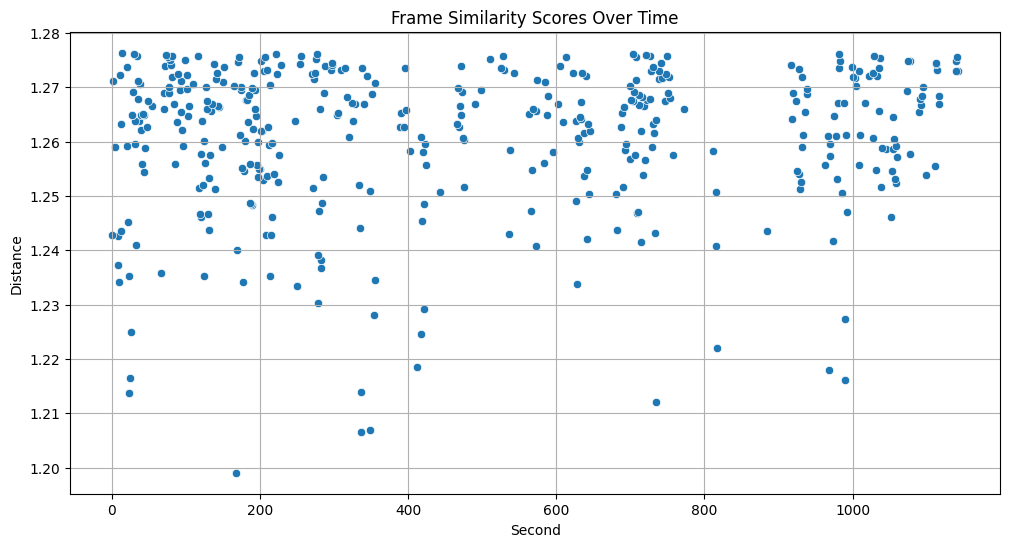

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_similarity_scores(results):
    data = {
        'sec': [int(id.split('_')[1].split('.')[0]) for id in results['ids'][0]],
        'distance': results['distances'][0]
    }
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='sec', y='distance', data=df, marker='o')
    plt.title('Frame Similarity Scores Over Time')
    plt.xlabel('Second')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

# Assuming `results` is the object containing 'ids' and 'distances'
plot_similarity_scores(results)

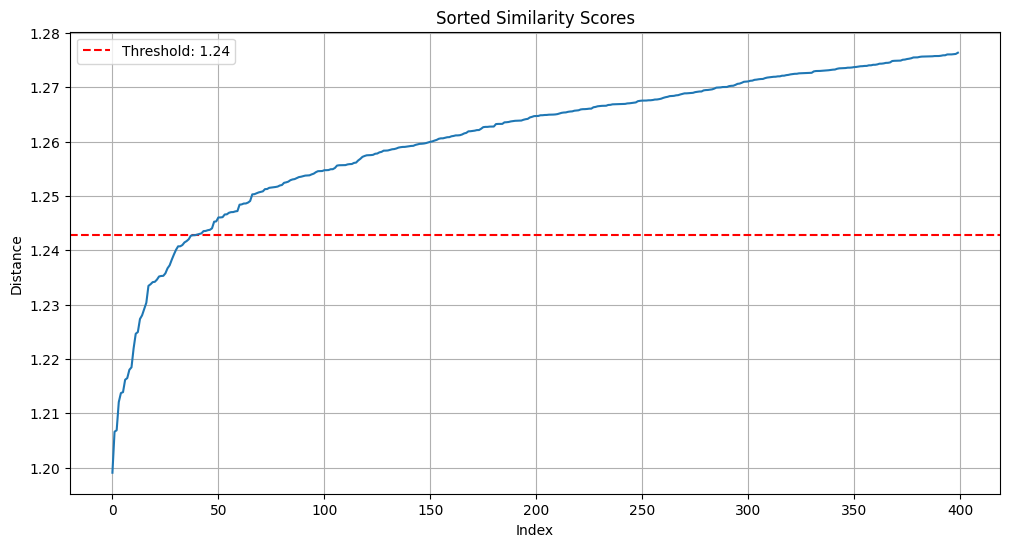

In [38]:
def plot_sorted_similarity_scores(results, threshold):
    distances = sorted(results['distances'][0])
    df = pd.DataFrame({'index': range(len(distances)), 'distance': distances})

    plt.figure(figsize=(12, 6))
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:0.2f}')
    sns.lineplot(x='index', y='distance', data=df)
    plt.title('Sorted Similarity Scores')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()


# Assuming `results` is the object containing 'ids' and 'distances'

plot_sorted_similarity_scores(results, threshold)

In [40]:
results['distances']

[[1.1990532875061035,
  1.2066001892089844,
  1.2068639993667603,
  1.212058424949646,
  1.2137104272842407,
  1.2138841152191162,
  1.2161606550216675,
  1.2164664268493652,
  1.2179945707321167,
  1.2184537649154663,
  1.2219452857971191,
  1.2246251106262207,
  1.224942922592163,
  1.227339267730713,
  1.228020191192627,
  1.2291746139526367,
  1.2303390502929688,
  1.233439326286316,
  1.233738899230957,
  1.2341251373291016,
  1.2341831922531128,
  1.2345833778381348,
  1.2351640462875366,
  1.2352579832077026,
  1.2352802753448486,
  1.2357430458068848,
  1.2366670370101929,
  1.2372193336486816,
  1.2382469177246094,
  1.2391935586929321,
  1.2400649785995483,
  1.2407112121582031,
  1.2407203912734985,
  1.240944743156433,
  1.241432785987854,
  1.2416754961013794,
  1.2420111894607544,
  1.242668628692627,
  1.242750883102417,
  1.2427668571472168,
  1.2428733110427856,
  1.2429893016815186,
  1.243097186088562,
  1.243518352508545,
  1.2435433864593506,
  1.2436782121658325,


In [45]:
threshold_indices = [
    int(i.split(".")[0].split("_")[-1]) for i, d in 
    zip(results['ids'][0], results['distances'][0])
    if d < threshold]

#threshold_indices = results['ids'][0][:int(0.1 * n_results)]

threshold_indices.sort()
threshold_indices

[8,
 9,
 10,
 23,
 24,
 25,
 26,
 33,
 67,
 125,
 168,
 169,
 177,
 208,
 214,
 215,
 250,
 278,
 279,
 282,
 283,
 336,
 337,
 349,
 354,
 355,
 412,
 418,
 421,
 572,
 628,
 642,
 714,
 734,
 815,
 817,
 968,
 974,
 989,
 990]

In [46]:
threshold_indices

[8,
 9,
 10,
 23,
 24,
 25,
 26,
 33,
 67,
 125,
 168,
 169,
 177,
 208,
 214,
 215,
 250,
 278,
 279,
 282,
 283,
 336,
 337,
 349,
 354,
 355,
 412,
 418,
 421,
 572,
 628,
 642,
 714,
 734,
 815,
 817,
 968,
 974,
 989,
 990]

In [49]:
def find_subregions_with_few_gaps(nums, max_gap=5, min_length=3):
    subregions = []
    start = nums[0]
    last = nums[0]
    
    for num in nums[1:]:
        if num - last > max_gap + 1:
            if last - start > min_length:
                subregions.append((start, last))
            start = num
        last = num
    

    if last - start > min_length:
        subregions.append((start, last))  # append the last region
    return subregions

find_subregions_with_few_gaps(threshold_indices)

[(208, 215), (278, 283), (349, 355), (412, 421), (968, 974)]

In [55]:
def extract_clips(input_video, output_folder, regions):
    input_path = Path(input_video)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    
    for i, (start, end) in enumerate(regions):
        start_time = start
        duration = (end + 1) - start
        output_clip_path = output_folder / f'clip_{i+1}.mp4'

        print(f"Extracting clip {i+1} from {start_time} to {end + 1}...")
        subprocess.run([
            'ffmpeg', '-i', str(input_path), '-ss', str(start_time), '-t', str(duration),
            '-c', 'copy', str(output_clip_path)
        ], check=True)
        
        print(f"Clip {i+1} saved to {output_clip_path}")

extract_clips('vids/arborist.mp4', 'vids/clips', find_subregions_with_few_gaps(threshold_indices))

Extracting clip 1 from 208 to 216...


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

Clip 1 saved to vids/clips/clip_1.mp4
Extracting clip 2 from 278 to 284...
Clip 2 saved to vids/clips/clip_2.mp4
Extracting clip 3 from 349 to 356...


Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'vids/arborist.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    creation_time   : 2020-10-26T19:52:09.000000Z
  Duration: 00:19:37.83, start: 0.000000, bitrate: 2218 kb/s
  Stream #0:0[0x1](und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(tv, bt709, progressive), 1280x720 [SAR 1:1 DAR 16:9], 2087 kb/s, 29.97 fps, 29.97 tbr, 30k tbn (default)
    Metadata:
      creation_time   : 2020-10-26T19:52:09.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 10/26/2020.
      vendor_id       : [0][0][0][0]
  Stream #0:1[0x2](eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 127 kb/s (default)
    Metadata:
      creation_time   : 2020-10-26T19:52:09.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 10/26/2020.
      vendor_id       : [0][0][0][0]
Output #0, mp4, to 'vids/clips/clip_2.mp4':
  Metadata:
    major_bran

Clip 3 saved to vids/clips/clip_3.mp4
Extracting clip 4 from 412 to 422...


[out#0/mp4 @ 0x1456040a0] video:1551kB audio:156kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.446496%
size=    1715kB time=00:00:09.99 bitrate=1404.9kbits/s speed=  57x    
ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2

Clip 4 saved to vids/clips/clip_4.mp4
Extracting clip 5 from 968 to 975...
Clip 5 saved to vids/clips/clip_5.mp4


[out#0/mp4 @ 0x11c704f20] video:913kB audio:109kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.508224%
size=    1027kB time=00:00:06.98 bitrate=1204.9kbits/s speed=17.9x    


In [68]:
video_instruction = """\
Use your professional video editing skills to make a cool tree cutting montage for an arborist business.
Go wild with the editing and keep the tone casual.
"""
#Keep it light on text, jokes are preferred over descriptive labels.

clip_info = """\
Your clips are as follows:

clip_1.mp4: 8 seconds, a man climbing a tree
clip_2.mp4: 6 seconds, a man climbing a tree
clip_3.mp4: 7 seconds, a man climbing a tree
clip_4.mp4: 10 seconds, a man climbing a tree
clip_5.mp4: 7 seconds, a man climbing a tree

They are all in the vids/clips folder.
Do not make up any assets. It will cause an error.
"""

In [69]:

vlog_prompt = """
# Editly Documentation

Here is the documentation for Editly, the editing software that we are using:

#### Layer type 'image'

Full screen image

| Parameter  | Description | Default | |
|-|-|-|-|
| `path` | Path to image file | | |
| `resizeMode` | See [Resize modes](#resize-modes) | | |

See also See [Ken Burns parameters](#ken-burns-parameters).

#### Layer type 'image-overlay'

Image overlay with a custom position and size on the screen. NOTE: If you want to use animated GIFs use `video` instead.

| Parameter  | Description | Default | |
|-|-|-|-|
| `path` | Path to image file | | |
| `position` | See [Position parameter](#position-parameter) | | |
| `width` | Width (from 0 to 1) where 1 is screen width | | |
| `height` | Height (from 0 to 1) where 1 is screen height | | |

See also [Ken Burns parameters](#ken-burns-parameters).

#### Layer type 'title'
- `fontPath` - See `defaults.layer.fontPath`
- `text` - Title text to show, keep it short
- `textColor` - default `#ffffff`
- `position` - See [Position parameter](#position-parameter)

See also [Ken Burns parameters](#ken-burns-parameters)

#### Layer type 'subtitle'
- `fontPath` - See `defaults.layer.fontPath`
- `text` - Subtitle text to show
- `textColor` - default `#ffffff`

#### Layer type 'title-background'

Title with background

- `text` - See type `title`
- `textColor` - See type `title`
- `background` - `{ type, ... }` - See type `radial-gradient`, `linear-gradient` or `fill-color`
- `fontPath` - See type `title`

#### Layer type 'news-title'
- `fontPath` - See `defaults.layer.fontPath`
- `text`
- `textColor` - default `#ffffff`
- `backgroundColor` - default `#d02a42`
- `position` - See [Position parameter](#position-parameter)

#### Layer type 'slide-in-text'
- `fontPath` - See `defaults.layer.fontPath`
- `text`
- `fontSize`
- `charSpacing`
- `color`
- `position` - See [Position parameter](#position-parameter)

#### Layer type 'fill-color', 'pause'
- `color` - Color to fill background, default: randomize

#### Layer type 'radial-gradient'
- `colors` - Array of two colors, default: randomize

#### Layer type 'linear-gradient'
- `colors` - Array of two colors, default: randomize

#### Layer type 'rainbow-colors'

🌈🌈🌈

#### Layer type 'canvas'

See [customCanvas.js](examples/customCanvas.js)

- `func` - Custom JavaScript function

#### Layer type 'fabric'

See [customFabric.js](examples/customFabric.js)

- `func` - Custom JavaScript function

#### Layer type 'gl'

Loads a GLSL shader. See [gl.json5](examples/gl.json5) and [rainbow-colors.frag](shaders/rainbow-colors.frag)

- `fragmentPath`
- `vertexPath` (optional)

### Arbitrary audio tracks

`audioTracks` property can optionally contain a list of objects which specify audio tracks that can be started at arbitrary times in the final video. These tracks will be mixed together (`mixVolume` specifying a relative number for how loud each track is compared to the other tracks). Because audio from `clips` will be mixed separately from `audioTracks`, `clipsAudioVolume` specifies the volume of the **combined** audio from `clips` relative to the volume of **each of the audio tracks** from `audioTracks`.

| Parameter | Description | Default | |
|-|-|-|-|
| `audioTracks[].path` | File path for this track | | |
| `audioTracks[].mixVolume` | Relative volume for this track | `1` | |
| `audioTracks[].cutFrom` | Time value to cut source file **from** | `0` | sec |
| `audioTracks[].cutTo` | Time value to cut source file **to** | | sec |
| `audioTracks[].start` | How many seconds into video to start this audio track | `0` | sec |

The difference between `audioTracks` and **Layer type 'audio'** is that `audioTracks` will continue to play across multiple `clips` and can start and stop whenever needed.

See `audioTracks` [example](examples/audio2.json5)

See also **Layer type 'detached-audio'**.

### Audio normalization

You can enable audio normalization of the final output audio. This is useful if you want to achieve Audio Ducking (e.g. automatically lower volume of all other tracks when voice-over speaks).

`audioNorm` parameters are [documented here.](https://ffmpeg.org/ffmpeg-filters.html#dynaudnorm)

[Example of audio ducking](examples/audio2.json5)

### Resize modes

`resizeMode` - How to fit image to screen. Can be one of:
- `contain` - All the video will be contained within the frame and letterboxed
- `contain-blur` - Like `contain`, but with a blurred copy as the letterbox
- `cover` - Video be cropped to cover the whole screen (aspect ratio preserved)
- `stretch` - Video will be stretched to cover the whole screen (aspect ratio ignored).

Default `contain-blur`.

See:
- [image.json5](examples/image.json5)
- [videos.json5](examples/videos.json5)

### Position parameter

Certain layers support the position parameter

`position` can be one of either:
  - `top`, `bottom` `center`, `top-left`, `top-right`, `center-left`, `center-right`, `bottom-left`, `bottom-right`
  - An object `{ x, y, originX = 'left', originY = 'top' }`, where `{ x: 0, y: 0 }` is the upper left corner of the screen, and `{ x: 1, y: 1 }` is the lower right corner, `x` is relative to video width, `y` to video height. `originX` and `originY` are optional, and specify the position's origin (anchor position) of the object.

See [position.json5](examples/position.json5)

### Ken Burns parameters

| Parameter  | Description | Default | |
|-|-|-|-|
| `zoomDirection` | Zoom direction for Ken Burns effect: `in`, `out`, `left`, `right` or `null` to disable | | |
| `zoomAmount` | Zoom amount for Ken Burns effect | `0.1` | |


# Your Mission

I need you to use our clips and suggest the clips section of the json.
It looks like this:

clips: [
    { duration: 3, transition: { name: 'directional-left' }, layers: [{ type: 'title-background', text: 'EDITLY\nVideo editing framework', background: { type: 'linear-gradient', colors: ['#02aab0', '#00cdac'] } }] },
    { duration: 4, transition: { name: 'dreamyzoom' }, layers: [{ type: 'title-background', text: 'Multi-line text with animated linear or radial gradients', background: { type: 'radial-gradient' } }] },
    { duration: 3, transition: { name: 'directional-right' }, layers: [{ type: 'rainbow-colors' }, { type: 'title', text: 'Colorful backgrounds' }] },
    { duration: 3, layers: [{ type: 'pause' }, { type: 'title', text: 'and separators' }] },

    { duration: 3, transition: { name: 'fadegrayscale' }, layers: [{ type: 'title-background', text: 'Image slideshows with Ken Burns effect', background: { type: 'linear-gradient' } }] },
    { duration: 2.5, transition: { name: 'directionalWarp' }, layers: [{ type: 'image', path: './assets/vertical.jpg', zoomDirection: 'out' }] },
    { duration: 3, transition: { name: 'dreamyzoom' }, layers: [{ type: 'image', path: './assets/img1.jpg', duration: 2.5, zoomDirection: 'in' }, { type: 'subtitle', text: 'Indonesia has many spectacular locations. Here is the volcano Kelimutu, which has three lakes in its core, some days with three different colors!' }, { type: 'title', position: 'top', text: 'With text' }] },
    { duration: 3, transition: { name: 'colorphase' }, layers: [{ type: 'image', path: './assets/img2.jpg', zoomDirection: 'out' }, { type: 'subtitle', text: 'Komodo national park is the only home of the endangered Komodo dragons' }] },
    { duration: 2.5, transition: { name: 'simplezoom' }, layers: [{ type: 'image', path: './assets/img3.jpg', zoomDirection: 'in' }] },

    { duration: 1.5, transition: { name: 'crosszoom', duration: 0.3 }, layers: [{ type: 'video', path: 'assets/kohlipe1.mp4', cutTo: 58 }, { type: 'title', text: 'Videos' }] },
    { duration: 3, transition: { name: 'fade' }, layers: [{ type: 'video', path: 'assets/kohlipe1.mp4', cutFrom: 58 }] },
    { transition: { name: 'fade' }, layers: [{ type: 'video', path: 'assets/kohlipe2.mp4', cutTo: 2.5 }] },
    { duration: 1.5, layers: [{ type: 'video', path: 'assets/kohlipe3.mp4', cutFrom: 3, cutTo: 30 }] },

    { duration: 3, transition: { name: 'crosszoom' }, layers: [{ type: 'gl', fragmentPath: './assets/shaders/3l23Rh.frag' }, { type: 'title', text: 'OpenGL\nshaders' }] },
    { duration: 3, layers: [{ type: 'gl', fragmentPath: './assets/shaders/MdXyzX.frag' }] },
    { duration: 3, layers: [{ type: 'gl', fragmentPath: './assets/shaders/30daysofshade_010.frag' }] },
    { duration: 3, layers: [{ type: 'gl', fragmentPath: './assets/shaders/wd2yDm.frag', speed: 5 }] },

    { duration: 3, layers: [
      { type: 'image', path: './assets/91083241_573589476840991_4224678072281051330_n.jpg' },
      { type: 'news-title', text: 'BREAKING NEWS' },
      { type: 'subtitle', text: 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur.', backgroundColor: 'rgba(0,0,0,0.5)' }
    ] },

    { duration: 3, layers: [
      { type: 'rainbow-colors' },
      { type: 'video', path: './assets/tungestolen.mp4', resizeMode: 'contain', width: 0.4, height: 0.4, top: 0.05, left: 0.95, originY: 'top', originX: 'right' },
      { type: 'title', position: 'bottom', text: 'Picture-in-Picture' }
    ] },

    { duration: 3, layers: [{ type: 'editly-banner' }] },
  ],

Use `cutTo` and `cutFrom` to ensure that clips are not sped up or slowed down (and ensure that your start and end are within the clip's length).
Additionally, there is a file shaders/rainbow.frag with a cool rainbow shader. Use it wisely.

I want you to include at least segments of every clip. 
""" + video_instruction + clip_info

In [ ]:
# client setup
from openai import OpenAI
client = OpenAI()

In [70]:

def generate_edit_instructions(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prompt}
        ],
        response_format= { "type": "json_object" }
    )
    plan =  response.choices[0].message.content
    assert plan is not None
    with open("spec.json", "w") as f:
        f.write(plan)

    return plan

In [71]:
plan = generate_edit_instructions(vlog_prompt)